#### Diversity analysis

In [2]:
#loading packages

library(tidyverse)
library(data.table)
library(reshape2)
library(reshape)
library(ggplot2)
library(RColorBrewer)
library(vegan)
library(phyloseq)
library(dplyr) 
library(ggpubr)
library(Hmisc)
library(corrplot)
library(scales)
library(broom)
library(ecodist)

In [3]:
#loading frequency table with taxonomic annotation

ReadCounts_TaxAnnotation <- read.delim("data/ReadCounts_TaxAnnotation.txt", h=T)

#### Rarefaction analysis

In [4]:
df <- ReadCounts_TaxAnnotation[,c("ID_Sample", "Species")]
dftable <- as.matrix(table(df))

In [5]:
raremax <- min(rowSums(dftable))
raremax

[1] 118

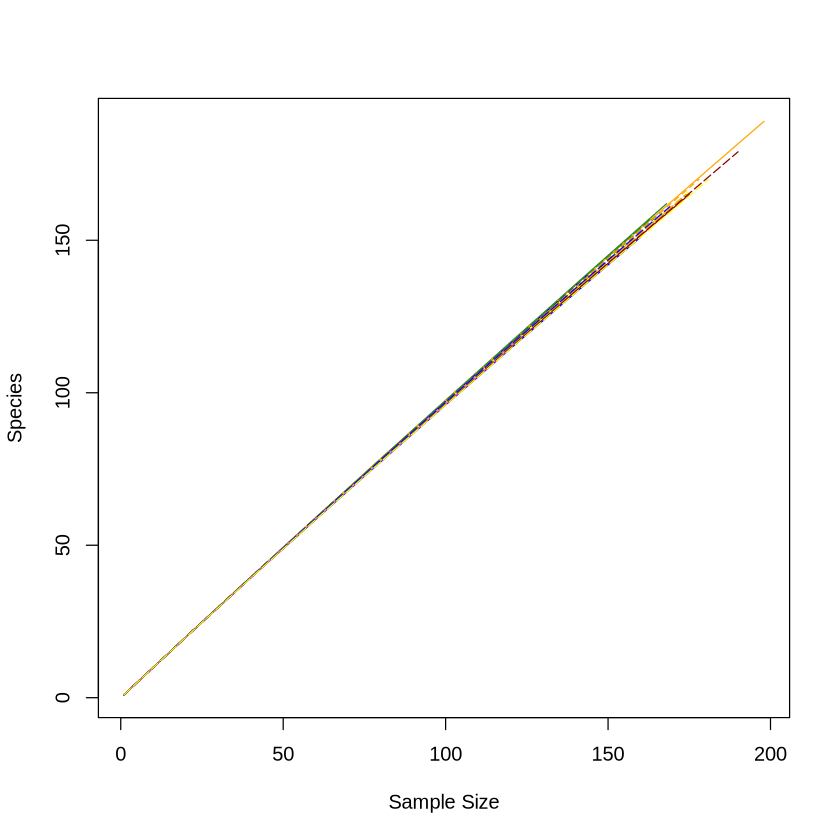

In [6]:
col <- c("black", "darkred", "forestgreen", "orange", "blue", "yellow", "hotpink")
lty <- c("solid", "dashed", "longdash", "dotdash")
pars <- expand.grid(col = col, lty = lty, stringsAsFactors = FALSE)

out <- with(pars[1:20, ],
            rarecurve(dftable, step = 20, col = col, lty = lty, label = FALSE))

In [7]:
df <- aggregate(ReadCounts_TaxAnnotation$Counts, list(ReadCounts_TaxAnnotation$Genus, ReadCounts_TaxAnnotation$ID_Sample), FUN=sum) 
colnames(df) <- c("Genus", "ID_Sample", "Counts")
cast_data = acast(df, ID_Sample ~ Genus)
cast_data[is.na(cast_data)] <- 0

Using Counts as value column: use value.var to override.



In [8]:
raremax <- min(rowSums(cast_data))
raremax

[1] 2251

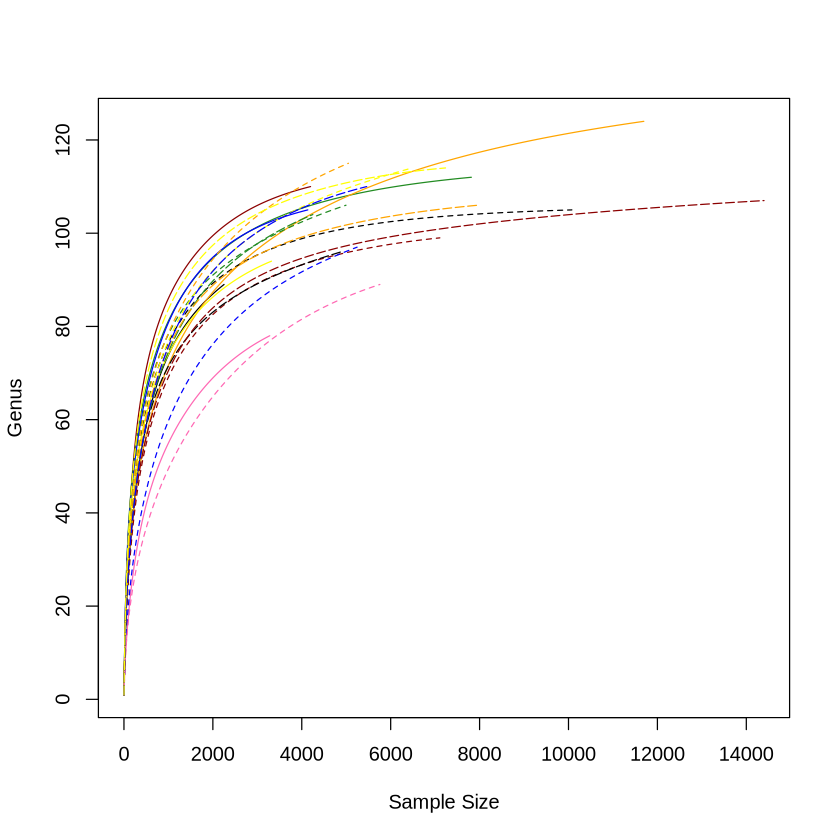

In [9]:
col <- c("black", "darkred", "forestgreen", "orange", "blue", "yellow", "hotpink")
lty <- c("solid", "dashed", "longdash", "dotdash")
pars <- expand.grid(col = col, lty = lty, stringsAsFactors = FALSE)

out <- with(pars[1:20, ],
            rarecurve(cast_data, step = 20, col = col, lty = lty, label = FALSE, ylab = "Genus"))

#### Alpha diversity

In [10]:
metadata <- read.delim("data/metadata_nreads.tsv", h=T)

In [11]:
rarefied_data <- rrarefy(cast_data, raremax)

In [12]:
OTU = otu_table(rarefied_data, taxa_are_rows = FALSE)
sampledata = sample_data(metadata)
rownames(sampledata) <- sampledata$ID_Sample
sampledata <- sampledata[,-1]
physeq1 = phyloseq(OTU,sampledata)

In [13]:
richness <- estimate_richness(physeq1)

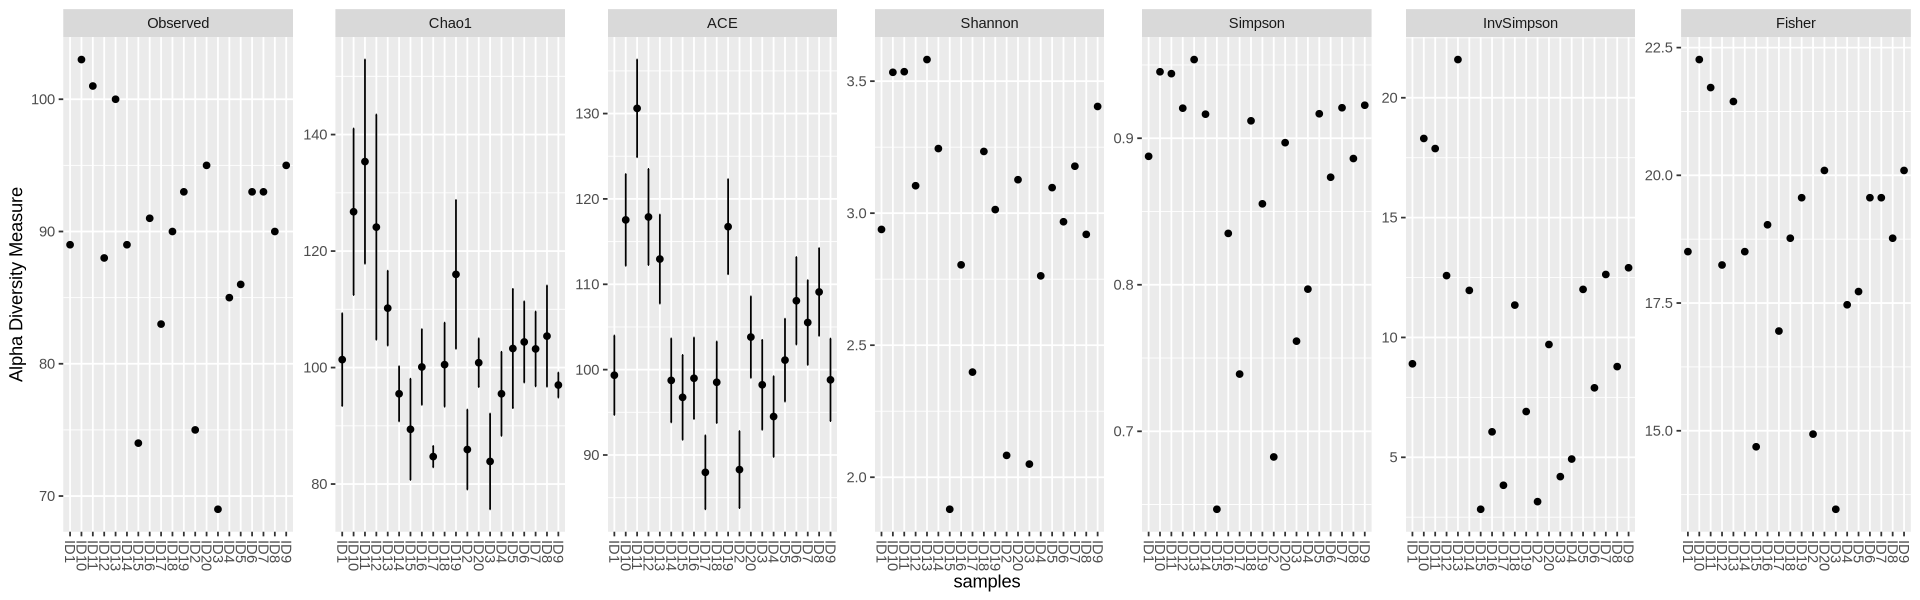

In [14]:
options(repr.plot.width=16, repr.plot.height=5)
plot_richness(physeq1, )

In [15]:
options(repr.plot.width=6, repr.plot.height=5)

a_my_comparisons <- list(c("LFD", "LFD + OVA"), 
                         c("LFD", "HFD"), 
                         c("LFD", "HFD + OVA"), 
                         c("LFD + OVA", "HFD"),
                         c("LFD + OVA", "HFD + OVA"),
                         c("HFD", "HFD + OVA"))


symnum.args = list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05, 1), symbols = c("****", "***", "**", "*", "ns"))

A <- plot_richness(physeq1, x="ExperimentalGroup", measures="Observed", color = "ExperimentalGroup")+
                   geom_boxplot(alpha=0.6)+ 
                   theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1,vjust=1,size=12))+
                   stat_compare_means(method = "wilcox.test", comparisons = a_my_comparisons, label = "p.signif", symnum.args = symnum.args)

B <- plot_richness(physeq1, x="ExperimentalGroup", measures="Chao1", color = "ExperimentalGroup")+
                   geom_boxplot(alpha=0.6)+ 
                   theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1,vjust=1,size=12))+
                   stat_compare_means(method = "wilcox.test", comparisons = a_my_comparisons, label = "p.signif", symnum.args = symnum.args)

C <- plot_richness(physeq1, x="ExperimentalGroup", measures="Shannon", color = "ExperimentalGroup")+
                   geom_boxplot(alpha=0.6)+ 
                   theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1,vjust=1,size=12))+
                   stat_compare_means(method = "wilcox.test", comparisons = a_my_comparisons, label = "p.signif", symnum.args = symnum.args)

D <- plot_richness(physeq1, x="ExperimentalGroup", measures="Simpson", color = "ExperimentalGroup")+
                   geom_boxplot(alpha=0.6)+ 
                   theme(legend.position="none", axis.text.x=element_text(angle=45,hjust=1,vjust=1,size=12))+
                   stat_compare_means(method = "wilcox.test", comparisons = a_my_comparisons, label = "p.signif", symnum.args = symnum.args)



Warning message in wilcox.test.default(c(89, 75, 69, 85, 86), c(103, 93, 93, 90, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(89, 75, 69, 85, 86), c(101, 88, 100, 89, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(103, 93, 93, 90, 95), c(101, 88, 100, 89, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(103, 93, 93, 90, 95), c(91, 83, 90, 93, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(101.363636363636, 85.9285714285714, 83.8823529411765, :
“cannot compute exact p-value with ties”


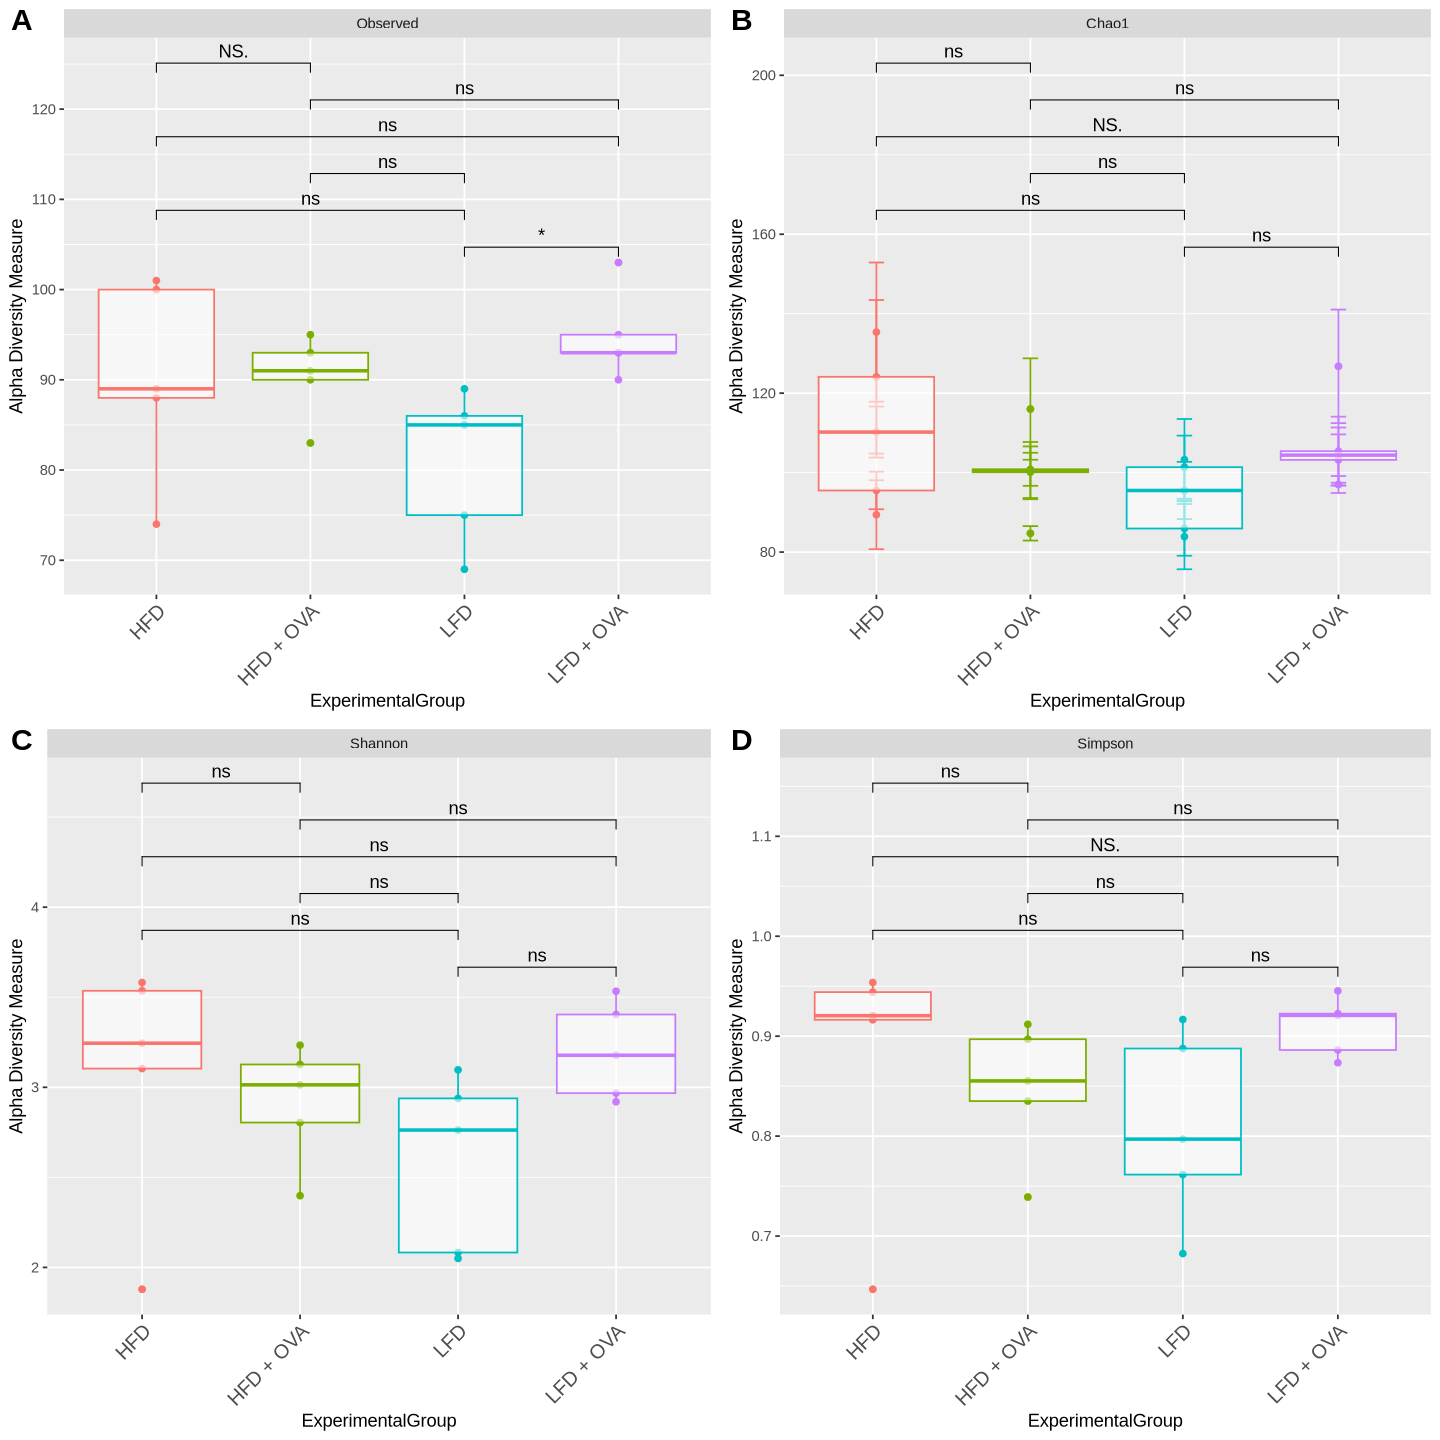

In [16]:
options(repr.plot.width=12, repr.plot.height=12)

ggarrange(A, B, C, D, 
          labels = c("A", "B", "C", "D"),
          font.label = list(size = 18),
          ncol = 2, nrow = 2)

#### Beta diversity

In [18]:
# Creating the relative abundance table
tcast_data <- t(cast_data)
relative_abundance <- (t(tcast_data) / apply(tcast_data, 2, sum))*100
relative_abundance <- t(relative_abundance)

# Calculates Bray-Curtis distances between samples
bray_curtis_dist <- vegan::vegdist(t(relative_abundance), method = "bray")
bray_curtis_pcoa <- ecodist::pco(bray_curtis_dist)

bray_curtis_pcoa_df <- data.frame(pcoa1 = bray_curtis_pcoa$vectors[,1], 
                                  pcoa2 = bray_curtis_pcoa$vectors[,2],
                                  pcoa3 = bray_curtis_pcoa$vectors[,3])

bray_curtis_pcoa_df$ID_Sample <- colnames(relative_abundance)
dist_metadata <- merge(metadata, bray_curtis_pcoa_df, by = "ID_Sample")

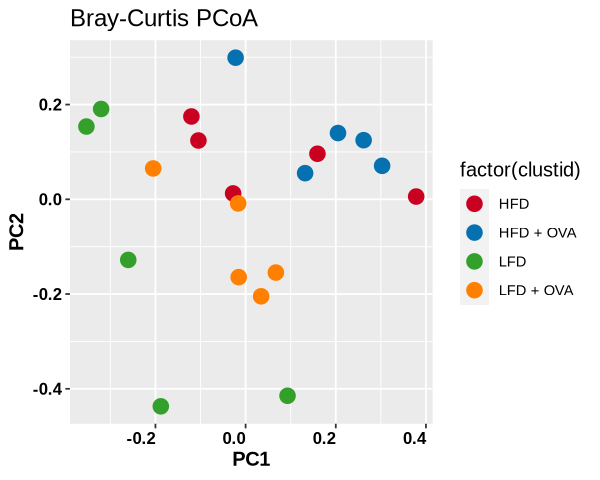

In [20]:
options(repr.plot.width=5, repr.plot.height=4)


clustid <- dist_metadata$ExperimentalGroup 
my_palette <- c("#ca0020", "#0571b0", "#33a02c","#ff7f00")
group <- c("LFD", "LFD + OVA", "HFD", "HFD + OVA")

dist_metadata$ExperimentalGroup <- factor(dist_metadata$ExperimentalGroup,
                                 levels = group, ordered = TRUE)


# Create a plot
bray_curtis_plot <- ggplot(data = dist_metadata, aes(x=pcoa1, y=pcoa2, color=factor(clustid))) +
  geom_point(size = 4) + 
  scale_color_manual(values = my_palette) +
  labs(x = "PC1",
       y = "PC2", 
       title = "Bray-Curtis PCoA") +
  theme(title = element_text(size = 12), # makes titles smaller
        axis.text.x = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text.y = element_text(hjust = 1, size = 10, colour = "black", face="bold"),
        axis.text = element_text(size = 12, colour = "black", face="bold"),
        axis.title = element_text(size = 12, colour = "black", face="bold"))
bray_curtis_plot